In [ ]:
! pip install densratio

In [10]:
# TODO

# 1.
# Make non-linear in such a way that you cannot extrapolate to unseen P(Y,X)

# 2. 
# Use importance estimation to extrapolate.

# 3. 
# Show that when H|Z vs Z|H, extrapolation fails even with importance estimation. 

# 4
# Make true model such that excluding variables should recover a model that is "robust" (P(X|H))

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 3]

In [651]:
def plot_dat(vars_):
    f, axes = plt.subplots(len(vars_), 1, sharex=True, figsize=(20, 10))

    for (H,title),ax in zip(vars_, axes):
        for i,h in zip(['A', 'B', 'C', 'D'], H):
            sns.distplot(h, label = i, ax=ax)
        ax.legend()
        ax.set_title(title)
        
    # plt.title(title)
    # plt.show()

In [1580]:
import numpy as np
from scipy.stats import gamma
import seaborn as sns
from copy import deepcopy

# Y := f(H, W, X, Z, N_Y)
# Y := f(W, X, Z, N_Y)
def fn(h, v, z, w):
    val = -1*(h > np.mean(h))*w*h**2 + w*h + w*z + np.random.normal(0, 5, size = h.shape[0])
    return val/10


def generate_data(N, fn, hidden_cause = True, plot=False, hiddens = [(20,2)]*4, v_conds = [(250,5,5)]*4):
    # H is latent variable, distribution changes (not )
    H = [gamma.rvs(a, loc=b, scale=1, size=N) for a,b in hiddens]

    # V := f(H, N_X)
    V = [(1/(h))*c + np.random.gamma(a, b, size=N) for h,(c,a,b) in zip(H, v_conds)]


    if not hidden_cause:
        V,H = deepcopy(H), deepcopy(V)

    # Z = [gamma.rvs(int(np.random.normal(40, 10)), loc=0, scale=1, size=N) for h in H]
    # Z := f(N_Z) 
    Z = [gamma.rvs(2, loc=1, scale=3, size=N) for h in H]

    # W := f(N_W) -- TREATMENT
    W = [np.random.binomial(1, 0.5, size=N) for h in H]

    # Y:= fn(H, V, Z, W, N_Y)
    Y = [fn(H[idx], V[idx], Z[idx], W[idx]) for idx in range(4)]

    taus = [fn(h,v,z,1) - fn(h,v,z,0) for h,v,z in zip(H,V,Z)]
    
    if plot:
        plot_dat([(H,'H'), (V, 'V') , (Z, 'Z'), (Y, 'Y'), (taus, 'tau')])

    return [(y, np.array([w,v,z]).T, tau) for y,v,z,w,h,tau in zip(Y, V, Z, W, H, taus)]

In [1702]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.neighbors.kde import KernelDensity
from scipy.stats import gaussian_kde
from scipy.stats import wasserstein_distance
from itertools import combinations

def kde_score(X):
    return gaussian_kde(X).evaluate

def score_wasserstein(dat, phi, model, train_idx):
    y_train, X_train, _ = dat[train_idx]
    model.fit(phi(X_train), y_train)
    resids = [model.predict(phi(x)) - y for y,x,_ in dat]
    dists = [wasserstein_distance(resids[0], r) for r in resids]
    mss = [np.mean(r**2) for r in resids]
    score = np.sum(dists)
    return score


def filter_dat(d, idxs):
    return [(y, x[:,idxs],tau) for y,x,tau in d]

def search_wasserstein(dat, phi, model, train_idx):
    s = dat[0][1].shape[1]

    combs = [j for i in range(1,s) 
             for j in combinations(range(1, s), i)]

    combs = [[0] + list(c) for c in combs]

    scores = [score_wasserstein(filter_dat(dat, i), phi, model, train_idx) for i in combs]

    return combs[np.argmin(scores)]


def run_model(dat, model, phi, train_idx, target_idx, use_weights = None, model_search = False):
    X_train, X_target = dat[train_idx][1], dat[target_idx][1]

    if model_search:
        # exclude the target in the model search
        dd = [d for i,d in enumerate(dat) if i != target_idx]
        idxs = search_wasserstein(dd, phi, model, train_idx)
        # print('Choosing variables: ', idxs)
    else:
        idxs = range(0, X_train.shape[1])


    if use_weights is not None:
        ps, pt = kde_score(X_train[:, use_weights]), kde_score(X_target[:, use_weights])
        weights = pt(X_train[:, use_weights]) / ps(X_train[:, use_weights])
    else:
        weights = np.ones(X_train.shape[0])


    d = [(phi(x[:, idxs]), x[:, 0], y) for y,x,tau in dat]

    model.fit(d[train_idx][0], d[train_idx][2], sample_weight=weights)

    y0 = [np.mean(model.predict(p[w == 0])) for p,w,y in d]
    y1 = [np.mean(model.predict(p[w == 1])) for p,w,y in d]

    pred_ates = [a-b for a,b in zip(y1, y0)]
    _, _, true_ates = zip(*dat)

    return [np.round(np.abs(p-np.mean(t)), 4) for p,t in zip(pred_ates, true_ates)]

phi = PolynomialFeatures(degree=3, include_bias=True).fit_transform

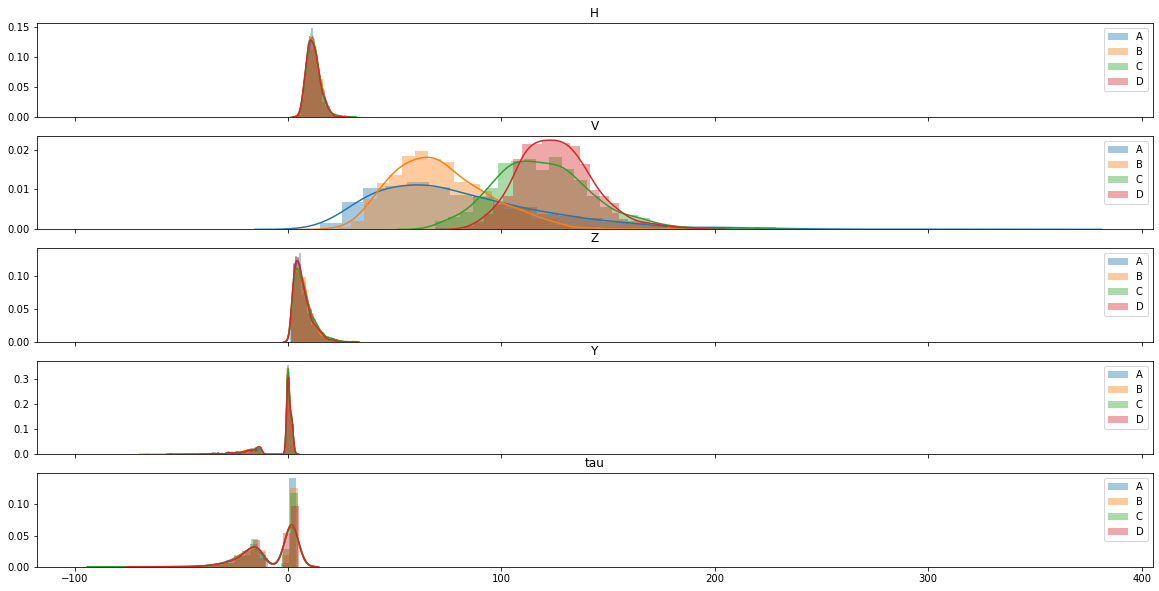

In [1766]:
# hiddens = [(20, 2), (4, 15), (4, 20), (2, 25)]
hiddens = [(10,2)]*4
# v_conds = [(500,2,2)]*4
v_conds = [(250,2,30), (250,5,10), (500,15,5), (500,40,2)]

dat = generate_data(1000, 
                    fn, 
                    hidden_cause = True, 
                    plot = True, 
                    hiddens = hiddens,
                    v_conds = v_conds)

In [1767]:
model = RandomForestRegressor(n_estimators=50, max_depth=2, min_samples_leaf=.05)

np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = None, model_search = True) for i in range(10)]), 0)

array([0.25584, 0.14942, 0.3557 , 0.08385])

In [1768]:
np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = None, model_search = False) for i in range(10)]), 0)

array([0.2394 , 0.26548, 1.55302, 1.26215])

In [1769]:
np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = 1, model_search = True) for i in range(10)]), 0)

array([1.74075, 1.56163, 1.85627, 1.47177])

In [1770]:
np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = 1, model_search = False) for i in range(10)]), 0)

array([3.20114, 3.08974, 1.91741, 1.4594 ])

In [1771]:
model = LinearRegression(fit_intercept=False)
run_model(dat, model, phi, 0, 3, use_weights = None, model_search = False)

[0.2417, 0.1241, 2.043, 1.8694]

In [1772]:
run_model(dat, model, phi, 0, 3, use_weights = None, model_search = True)

[0.2417, 0.1654, 0.4191, 0.0344]

In [1773]:
run_model(dat, model, phi, 0, 3, use_weights = 1, model_search = False)

[0.5055, 0.7213, 1.5729, 1.4425]

In [1774]:
run_model(dat, model, phi, 0, 3, use_weights = 1, model_search = True)

[1.6624, 1.4357, 1.656, 1.4094]

In [1744]:
# get residuals for "sets" separately
# compute distance between residuals
# optimize squared errors + penalty for residual distance

# search for "sets" by looking at residuals and fitting a mixture model
# then optimize to remove that mixture...

# set up an adversarial problem: the adversary tries to find a 
# mixture model in your reiduals, the classifier tries to make force the
# adversary to fit a 1-component mixture, for example... 